Bibliotecas importadas com sucesso.

Carregando os datasets (train, test, stores, features)...
Datasets carregados com sucesso.

Iniciando o pré-processamento e unificação dos dados...
Merge e tratamento de valores nulos concluídos para ambos os datasets.

Criando novas features para ambos os datasets...
Novas features criadas com sucesso.

Dividindo o dataset de treino em treino e validação (corte em 2012-01-01).
Tamanho do conjunto de treino: 294132 linhas
Tamanho do conjunto de validação: 127438 linhas

Iniciando o treinamento do modelo Random Forest...
Modelo treinado com sucesso.

Realizando previsões no conjunto de validação...
Avaliando a acurácia do modelo...

--- MÉTRICAS DE AVALIAÇÃO (no conjunto de validação) ---
Erro Absoluto Médio (MAE): $2,212.44
Erro Quadrático Médio (MSE): 24,155,887.21
Raiz do Erro Quadrático Médio (RMSE): $4,914.86


--- TOP 10 VARIÁVEIS MAIS IMPORTANTES ---
          feature  importancia
1            Dept     0.617077
12           Size     0.189565
0

C:\Users\aluno.servidorfatec\AppData\Local\Temp\ipykernel_3640\3358397210.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation_set['Predicted_Sales'] = predictions


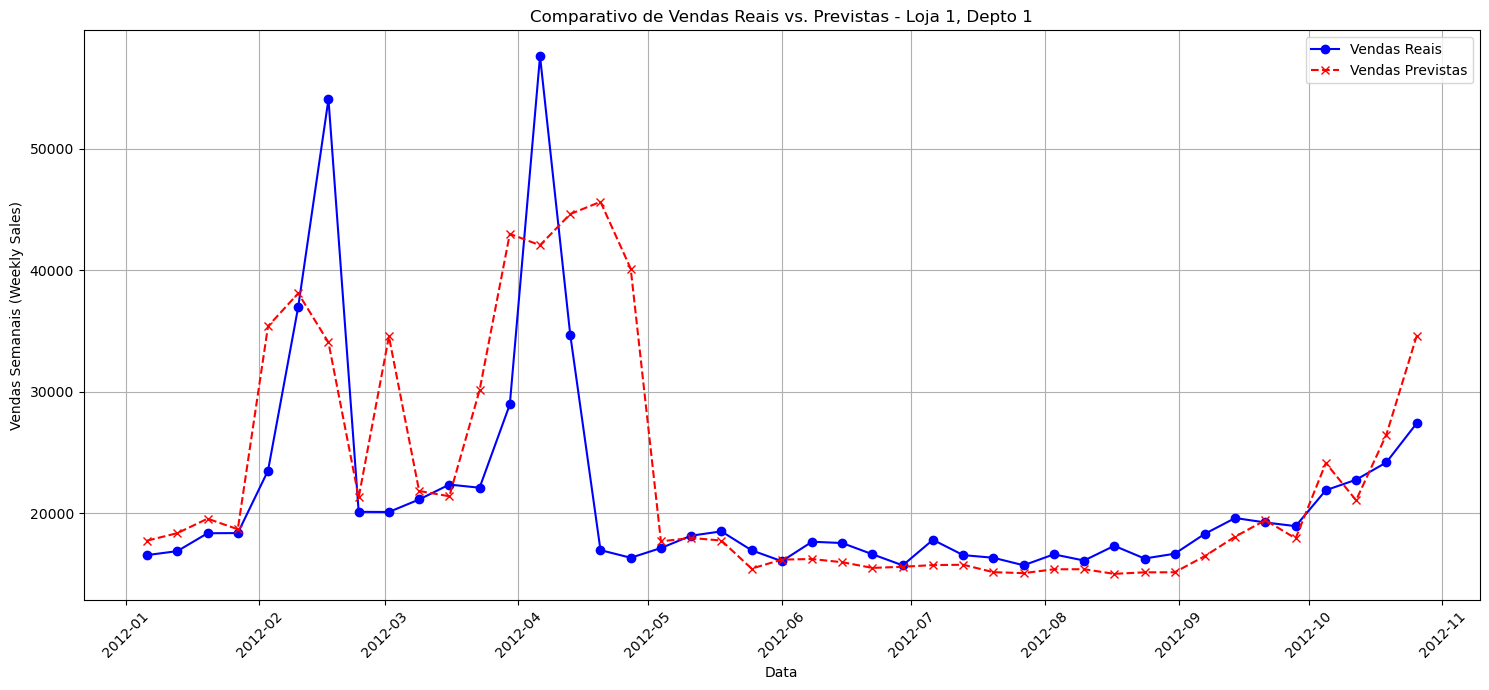

In [2]:
# ==============================================================================
# SEÇÃO 1: IMPORTAÇÃO DAS BIBLIOTECAS
# ==============================================================================
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
# --- IMPORTAÇÃO PARA GRÁFICOS ---
import matplotlib.pyplot as plt

print("Bibliotecas importadas com sucesso.")

# ==============================================================================
# SEÇÃO 2: CARREGAMENTO DOS DADOS
# ==============================================================================
print("\nCarregando os datasets (train, test, stores, features)...")
try:
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    df_stores = pd.read_csv('stores.csv')
    df_features = pd.read_csv('features.csv')
    print("Datasets carregados com sucesso.")
except FileNotFoundError as e:
    print(f"Erro: Arquivo não encontrado. Verifique se os arquivos CSV estão na mesma pasta que o script. Detalhe: {e}")
    exit()

# ==============================================================================
# SEÇÃO 3: MERGE E PRÉ-PROCESSAMENTO DOS DADOS
# ==============================================================================
print("\nIniciando o pré-processamento e unificação dos dados...")
df_features_stores = pd.merge(df_features, df_stores, on='Store', how='left')
df_train_completo = pd.merge(df_train, df_features_stores, on=['Store', 'Date', 'IsHoliday'], how='left')
df_test_completo = pd.merge(df_test, df_features_stores, on=['Store', 'Date', 'IsHoliday'], how='left')
df_train_completo.fillna(0, inplace=True)
df_test_completo.fillna(0, inplace=True)
print("Merge e tratamento de valores nulos concluídos para ambos os datasets.")

# ==============================================================================
# SEÇÃO 4: ENGENHARIA DE ATRIBUTOS (FEATURE ENGINEERING)
# ==============================================================================
print("\nCriando novas features para ambos os datasets...")
def criar_features(df):
    df['Date'] = pd.to_datetime(df['Date'])
    df['Ano'] = df['Date'].dt.year
    df['Mes'] = df['Date'].dt.month
    df['Dia'] = df['Date'].dt.day
    df['Semana_do_Ano'] = df['Date'].dt.isocalendar().week.astype(int)
    df['IsHoliday'] = df['IsHoliday'].astype(int)
    return df

df_train_final = criar_features(df_train_completo)
df_test_final = criar_features(df_test_completo)

df_full = pd.concat([df_train_final, df_test_final])
df_full = pd.get_dummies(df_full, columns=['Type'], prefix='Tipo')

df_train_final = df_full[df_full['Weekly_Sales'].notna()]
df_test_final = df_full[df_full['Weekly_Sales'].isna()]
print("Novas features criadas com sucesso.")

# ==============================================================================
# SEÇÃO 5: CRIANDO UM CONJUNTO DE VALIDAÇÃO
# ==============================================================================
data_corte_validacao = '2012-01-01'
print(f"\nDividindo o dataset de treino em treino e validação (corte em {data_corte_validacao}).")
train_set = df_train_final[df_train_final['Date'] < data_corte_validacao]
validation_set = df_train_final[df_train_final['Date'] >= data_corte_validacao]

target = 'Weekly_Sales'
features = [col for col in df_train_final.columns if col not in [target, 'Date']]

X_train = train_set[features]
y_train = train_set[target]
X_val = validation_set[features]
y_val = validation_set[target]
print(f"Tamanho do conjunto de treino: {len(X_train)} linhas")
print(f"Tamanho do conjunto de validação: {len(X_val)} linhas")

# ==============================================================================
# SEÇÃO 6: TREINAMENTO DO MODELO RANDOM FOREST
# ==============================================================================
print("\nIniciando o treinamento do modelo Random Forest...")
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, min_samples_leaf=2)
model.fit(X_train, y_train)
print("Modelo treinado com sucesso.")

# ==============================================================================
# SEÇÃO 7: PREVISÕES E AVALIAÇÃO DO MODELO NO CONJUNTO DE VALIDAÇÃO
# ==============================================================================
print("\nRealizando previsões no conjunto de validação...")
predictions = model.predict(X_val)
print("Avaliando a acurácia do modelo...")
mae = mean_absolute_error(y_val, predictions)
mse = mean_squared_error(y_val, predictions)
rmse = np.sqrt(mse)
print("\n--- MÉTRICAS DE AVALIAÇÃO (no conjunto de validação) ---")
print(f"Erro Absoluto Médio (MAE): ${mae:,.2f}")
print(f"Erro Quadrático Médio (MSE): {mse:,.2f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): ${rmse:,.2f}\n")

# ==============================================================================
# SEÇÃO 8: ANÁLISE DE IMPORTÂNCIA DAS VARIÁVEIS
# ==============================================================================
print("\n--- TOP 10 VARIÁVEIS MAIS IMPORTANTES ---")
importancia_features = pd.DataFrame({
    'feature': X_train.columns,
    'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False)
print(importancia_features.head(10))

# ==============================================================================
# SEÇÃO 9: GRÁFICO COMPARATIVO - REAL VS. PREVISTO (NOVA SEÇÃO)
# ==============================================================================
print("\nGerando gráfico comparativo para um exemplo (Loja 1, Depto 1)...")

# Adicionando as previsões ao DataFrame de validação para facilitar a plotagem
validation_set['Predicted_Sales'] = predictions

# --- FILTRE AQUI PARA MUDAR O EXEMPLO ---
store_id_exemplo = 1
dept_id_exemplo = 1
# ------------------------------------------

# Filtrando os dados para o exemplo específico
exemplo_df = validation_set[(validation_set['Store'] == store_id_exemplo) & (validation_set['Dept'] == dept_id_exemplo)]

# Criando a figura do gráfico
plt.figure(figsize=(15, 7))

# Plotando as vendas reais
plt.plot(exemplo_df['Date'], exemplo_df['Weekly_Sales'], label='Vendas Reais', color='blue', marker='o', linestyle='-')

# Plotando as vendas previstas pelo modelo
plt.plot(exemplo_df['Date'], exemplo_df['Predicted_Sales'], label='Vendas Previstas', color='red', marker='x', linestyle='--')

# Adicionando títulos e legendas para clareza
plt.title(f'Comparativo de Vendas Reais vs. Previstas - Loja {store_id_exemplo}, Depto {dept_id_exemplo}')
plt.xlabel('Data')
plt.ylabel('Vendas Semanais (Weekly Sales)')
plt.legend()
plt.grid(True) # Adiciona uma grade para melhor visualização
plt.xticks(rotation=45) # Rotaciona as datas no eixo X para não sobrepor
plt.tight_layout() # Ajusta o layout para não cortar os rótulos

# Exibindo o gráfico
plt.show()